# State of Charge Estimation with UKF
This notebook demonstrates the use of the Unscented Kalman Filter (UKF) for estimating the state of charge (SOC) of a lithium-ion battery cell. The UKF is a nonlinear version of the Kalman filter which can estimate the state of a system with nonlinear dynamics. The UKF is a popular choice for SOC estimation because does not require linearization of the battery model.

## Theory

### Unscented Transformation
Before we dive into the UKF equations, we need to understand concept of unscented transformation (UT). UT is a method for estimating the mean and covariance of a nonlinear function of a random variable. 

Consider propagating a random variable $\mathbf{x}$ through a nonlinear function $\mathbf{y}=f(\mathbf{x})$. Assume that $\mathbf{x}$ (dimension $N$) has a mean $\mathbf{\bar{x}}$ and covariance $\mathbf{P}$. To calculate statistics of $\mathbf{y}$, we form a set of $2N+1$ sigma points $\mathbf{X}_{i}$ (details later). The mean and covariance of $\mathbf{y}$ can then be approximated as:

$$
\begin{aligned}
\mathbf{Y}_{i} &=f\left(\mathbf{X}_{i}\right) \quad i=1, \ldots, 2 N+1 \\
\mathbf{y} &=\sum_{i=1}^{2 N+1} w_{i}^{m} \mathbf{Y}_{i} \\
\mathbf{P}_{y} &=\sum_{i=1}^{2 N+1} w_{i}^{c}\left(\mathbf{Y}_{i}-\mathbf{y}\right)\left(\mathbf{Y}_{i}-\mathbf{y}\right)^{T}
\end{aligned}
$$


### Sigma Points
The sigma points are formed by adding and subtracting a scaled version of the covariance matrix from the mean. The scaling parameter $\lambda$ is chosen to ensure that the sigma points are distributed around the mean. The sigma points are defined as follows:

$$
\begin{aligned}
\mathbf{X}_{i} &= \mathbf{x} \pm \left(\sqrt{\left(N+\lambda\right) \mathbf{P}}\right)_{i} \quad i=1, \ldots, N
\end{aligned}
$$
    
where $N$ is the number of states, $\lambda=\alpha^{2}\left(N+\kappa\right)-N$ is a scaling parameter, $\alpha$ determines the spread of the sigma points, and $\kappa$ is a secondary scaling parameter. The weights $w_{i}^{m}$ and $w_{i}^{c}$ are defined as follows:

$$
\begin{aligned}
w_{i}^{m} &=\left\{\begin{array}{ll}
\frac{\lambda}{N+\lambda} & i=1 \\
\frac{1}{2(N+\lambda)} & i=2, \ldots, 2 N+1
\end{array}\right. \\
w_{i}^{c} &=\left\{\begin{array}{ll}
\frac{\lambda}{N+\lambda}+\left(1-\alpha^{2}+\beta\right) & i=1 \\
\frac{1}{2(N+\lambda)} & i=2, \ldots, 2 N+1
\end{array}\right.
\end{aligned}
$$

where $\beta$ is a secondary scaling parameter. The parameters $\alpha$, $\kappa$, and $\beta$ are chosen to satisfy $\alpha^{2}>0$, $\kappa \geq 0$, and $0 \leq \beta \leq 3-N$. The values $\alpha=1$, $\kappa=0$, and $\beta=2$ are commonly used.


### Unscented Kalman Filter
Like EKF, UKF employs a two-step process—prediction and update—to estimate a system's state.

Utilizing sigma points, the UKF represents the system's state and covariance, predicting the next state by propagating these points through the system model. Subsequently, the predicted sigma points pass through the measurement model to anticipate measurements, which are used to correct the predicted state, yielding the final system state estimate. The UKF is defined by the following equations:

Prediction:
$$
\begin{aligned}
\mathbf{Y}_{i} &=f\left(\mathbf{X}_{i}, \mathbf{u}_{k-1}\right) \quad i=1, \ldots, 2 n \\
\mathbf{x}_{k}^{-} &=\sum_{i=1}^{2 n} w_{i}^{m} \mathbf{Y}_{i} \\
\mathbf{P}_{k}^{-} &=\sum_{i=1}^{2 n} w_{i}^{c}\left(\mathbf{Y}_{i}-\mathbf{x}_{k}^{-}\right)\left(\mathbf{Y}_{i}-\mathbf{x}_{k}^{-}\right)^{T}+\mathbf{Q}_{k}
\end{aligned}
$$

Update:
$$
\begin{aligned}
\mathbf{Y}_{i} &=h\left(\mathbf{X}_{i}\right) \quad i=1, \ldots, 2 n \\
\mathbf{y}_{k} &=\sum_{i=1}^{2 n} w_{i}^{m} \mathbf{Y}_{i} \\
\mathbf{S}_{k} &=\sum_{i=1}^{2 n} w_{i}^{c}\left(\mathbf{Y}_{i}-\mathbf{y}_{k}\right)\left(\mathbf{Y}_{i}-\mathbf{y}_{k}\right)^{T}+\mathbf{R}_{k} \\
\mathbf{C}_{k} &=\sum_{i=1}^{2 n} w_{i}^{c}\left(\mathbf{X}_{i}-\mathbf{x}_{k}^{-}\right)\left(\mathbf{Y}_{i}-\mathbf{y}_{k}\right)^{T} \\
\mathbf{K}_{k} &=\mathbf{C}_{k} \mathbf{S}_{k}^{-1} \\
\mathbf{x}_{k} &=\mathbf{x}_{k}^{-}+\mathbf{K}_{k}\left(\mathbf{z}_{k}-\mathbf{y}_{k}\right) \\
\mathbf{P}_{k} &=\mathbf{P}_{k}^{-}-\mathbf{K}_{k} \mathbf{S}_{k} \mathbf{K}_{k}^{T}
\end{aligned}
$$

where $\mathbf{X}_{i}$ and $\mathbf{Y}_{i}$ are the sigma points, $\mathbf{x}_{k}^{-}$ and $\mathbf{P}_{k}^{-}$ are the predicted state and covariance, $\mathbf{x}_{k}$ and $\mathbf{P}_{k}$ are the updated state and covariance, $\mathbf{Q}_{k}$ and $\mathbf{R}_{k}$ are the process and measurement noise covariance matrices, $\mathbf{z}_{k}$ is the measurement vector, $w_{i}^{m}$ and $w_{i}^{c}$ are the weights for the mean and covariance, and $\mathbf{K}_{k}$ is the Kalman gain.

In [1]:
import numpy as np

import sox.plant.protocol as protocol
from sox.system import IsothermalThevenin
from sox.plant import Thevenin, default_thevenin_inputs
from sox.sensor import Sensor
from sox.filter import (
    UnscentedKalmanFilter,
    MerweSigmaPoints,
)
from sox.utils import quick_plot

## Synthetic Data
Similar to EKF tutorial, we use Thevenin model with thermal effects to generate synthetic data.

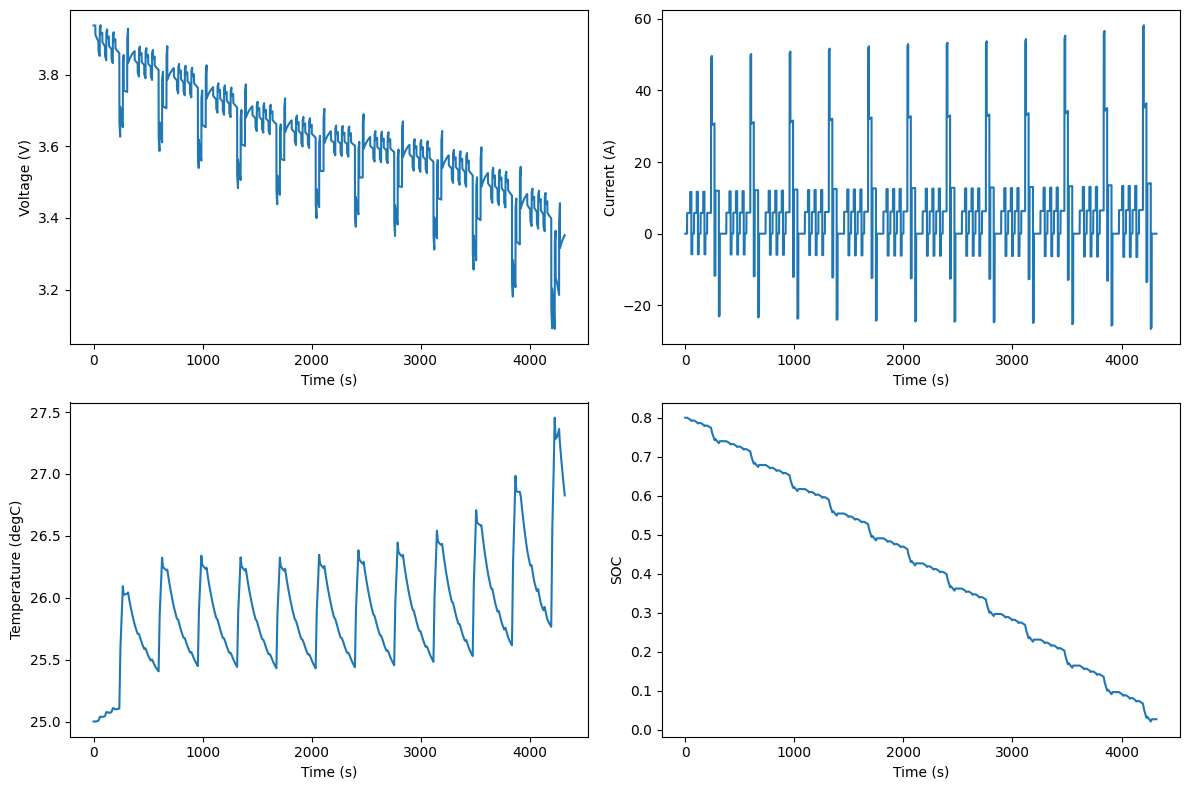

In [2]:
battery = Thevenin(default_thevenin_inputs)

dt = 1.0
solution = battery.solve(protocol.dst_schedule(peak_power=180, number_of_cycles=12, sampling_time_s=dt))

time = solution.time
voltage = solution.voltage
current = solution.current
soc = solution.soc
cell_temperature = solution.cell_temperature

quick_plot(
    time=[time],
    data=[voltage, current, cell_temperature, soc],
    legends=["voltage", "current", "temperature", "soc"],
    x_labels="Time (s)",
    y_labels=["Voltage (V)", "Current (A)", "Temperature (degC)", "SOC"],
)

## State Estimator

We here set up the dynamic system and corresponding UKF observer. The design choices are
1. Isothermal and 1-RC Thevenin model
2. Time-invariant model parameters and state transition matrices ($\mathbf{F}$ and $\mathbf{B}$)
3. Constant process and measurement noise covariance matrices ($\mathbf{Q}$ and $\mathbf{R}$)

In [39]:
system = IsothermalThevenin(
    ocv_func=default_thevenin_inputs.open_circuit_voltage,
    series_resistance=4e-3,  # true value: soc-dependent
    rc_resistors=[7e-3],  # true value: soc-dependent
    rc_capacitors=[8e3],  # true value: soc-dependent
    capacity=10,  # real value: 10
)

ukf = UnscentedKalmanFilter(
    Q=np.diag([0.01**2, 0.1**2]),
    R=1e-5,
    x0=np.array([0.75, 0.0]),
    P0=np.diag([1e-5, 1]),
    sigma_gen=MerweSigmaPoints(n=2, alpha=0.5, beta=2.0, kappa=0.0),
)

## Sensors

Each state estimator requires sensor readings as inputs. Here we set up the sensors to read the voltage and current data generated above. For simplicity, we assume that the sensors are perfect without faults or noise. We will study the effect of sensor noise on state estimation in a future tutorial.

In [33]:
voltage_sensor = Sensor(name="voltage", time=time, data=voltage)
current_sensor = Sensor(name="current", time=time, data=current)

## Run Estimation

We are now ready to run the state estimation. We first reset the sensors and the state estimator. Then we loop through the data and update the state estimator with the sensor readings. The state estimator returns the estimated SOC and the covariance of the SOC estimate. We store the SOC estimate and the SOC estimate covariance for later use.

In [40]:
v_sense = []
curr_sense = []
soc_ukf, soc_ukf_std, vrc_ukf_std = [], [], []

voltage_sensor.reset()
current_sensor.reset()
ukf.reset()

try:
    while True:
        # sensor readings
        voltage_reading = voltage_sensor.read()
        current_reading = current_sensor.read()

        # extended kalman filter
        ukf.predict(fx=system.fx, fx_args=(current_reading, dt))
        ukf.update(
            z=voltage_reading,
            hx=system.hx,
            hx_args=current_reading,
        )

        # store states and sensor readings
        soc_ukf.append(ukf.x[0, 0])
        soc_ukf_std.append(np.sqrt(ukf.P[0, 0]))
        vrc_ukf_std.append(np.sqrt(ukf.P[1, 1]))

        v_sense.append(voltage_reading)
        curr_sense.append(current_reading)

except IndexError as e:
    print(e)

Sensor 'voltage' finished reading.


## Plot Results

We now use `quick_plot` to plot the results. The true and (fault-less and noise-less) sensor readings, estimated states and statistics are plotted.

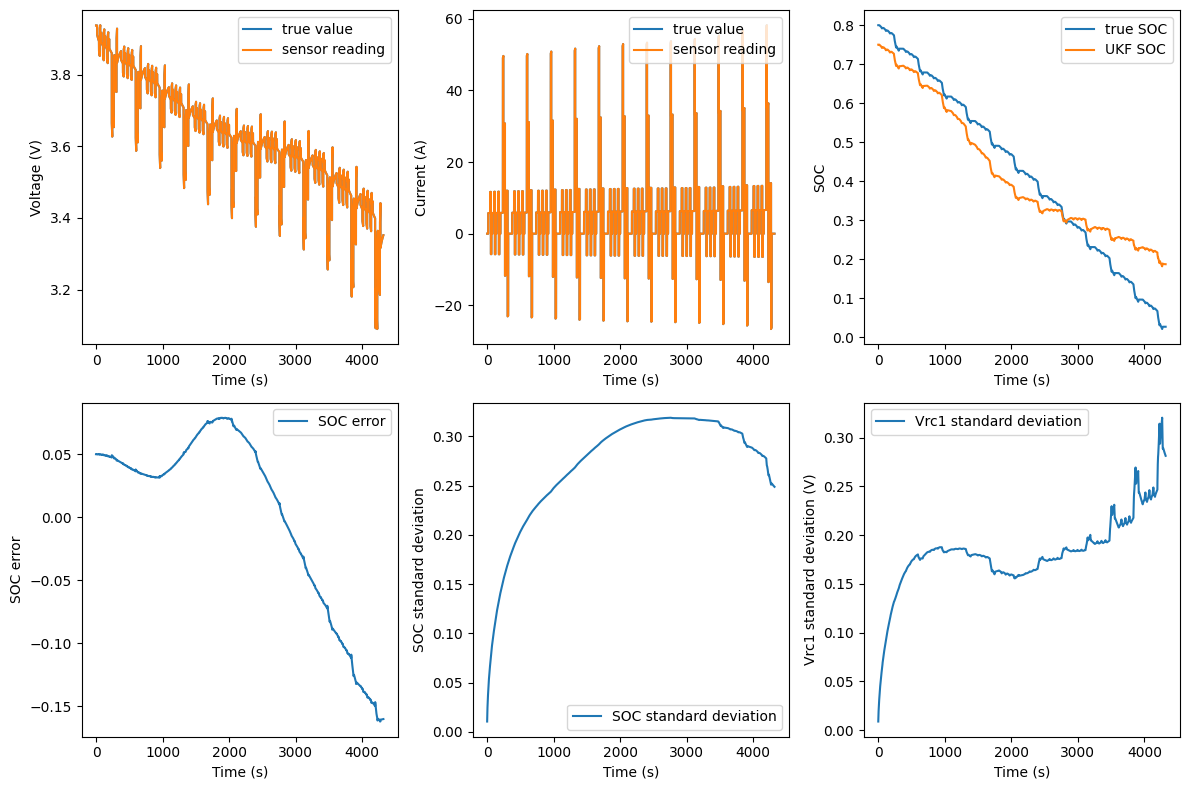

In [41]:
quick_plot(
    time=[time],
    data=[[voltage, v_sense], [current, curr_sense], [soc, soc_ukf], [soc - soc_ukf], [soc_ukf_std], [vrc_ukf_std]],
    legends=[
        ["true value", "sensor reading"],
        ["true value", "sensor reading"],
        ["true SOC", "UKF SOC"],
        ["SOC error"],
        ["SOC standard deviation"],
        ["Vrc1 standard deviation"],
    ],
    x_labels="Time (s)",
    y_labels=[
        "Voltage (V)",
        "Current (A)",
        "SOC",
        "SOC error",
        "SOC standard deviation",
        "Vrc1 standard deviation (V)",
    ],
    n_cols=3,
)

With the choices of sigma point parameters, we see that the UKF performs similar to the EKF, but with a few differences. For example, the SOC estimate covariance is smaller. The smoother SOC estimate is due to the fact that the UKF does not require linearization of the battery model, which is a source of error in the EKF. The smaller SOC estimate covariance is due to the fact that the UKF uses sigma points to approximate the state distribution, which is more accurate than the linearization used in the EKF.